# 3D AMRVAC

We create a Magrittetorch model from a snapshot of 3D AMRVAC hydrodynamics simulation.
The hydro model was kindly provided by Jan Bolte.
Currently, the AMRVAC binary files can not yet be used directly to extract the snapshot data.
Hence we use vtk package to read the corresponding `.vtu` files.

## Setup

Import the required functionalty.

In [1]:
import magrittetorch.tools.radiativetransferutils as rtutils
import magrittetorch.tools.mesher as mesher
import magrittetorch.tools.setup as setup
from scipy.spatial import cKDTree
import torch
import vtk
from vtk.util.numpy_support import vtk_to_numpy
from magrittetorch.model.model import Model # Model class
from magrittetorch.model.geometry.geometry import GeometryType # GeometryType enum
from magrittetorch.model.geometry.boundary import BoundaryType # BoundaryType enum
# import magritte.core  as magritte             # Core functionality
import plons                                  # Loading phantom data
import numpy          as np                   # Data structures
import warnings                               # Hide warnings
warnings.filterwarnings('ignore')             # especially for yt
import yt                                     # 3D plotting
import os

from tqdm           import tqdm               # Progress bars
from astropy        import constants, units   # Unit conversions
from scipy.spatial  import Delaunay           # Finding neighbors
from yt.funcs       import mylog              # To avoid yt output 
mylog.setLevel(40)     

Define a working directory (you will have to change this; it must be an **absolute path**).

In [2]:
wdir = "/lhome/thomasc/Magrittetorch-examples/AMRVAC_3D/"

Create the working directory.

In [3]:
!mkdir -p $wdir

Define file names.

In [4]:
input_file = os.path.join(wdir, 'model_AMRVAC_3D.vtu' )   # AMRVAC snapshot
model_file = os.path.join(wdir, 'model_AMRVAC_3D.hdf5')   # Resulting Magritte model
lamda_file = os.path.join(wdir, 'co.txt'              )   # Line data file

We use a snapshot and data file that can be downloaded with the following links.

In [5]:
input_link = "https://owncloud.ster.kuleuven.be/index.php/s/mqtDyDSMPm2TjmG/download"
lamda_link = "https://home.strw.leidenuniv.nl/~moldata/datafiles/co.dat"

Dowload the snapshot and the linedata (``%%capture`` is just used to suppress the output).

In [6]:
%%capture
!wget $input_link --output-document $input_file
!wget $lamda_link --output-document $lamda_file

## Extract data

The script below extracts the required data from the snapshot `.vtu` file.

In [7]:
# Create a vtk reader to read the AMRVAC file and extract its contents.
reader = vtk.vtkXMLUnstructuredGridReader()
reader.SetFileName(input_file)
reader.Update()

# Extract the grid output
grid = reader.GetOutput()

# Extract the number of cells
ncells = grid.GetNumberOfCells() 

# Extract cell data
cellData = grid.GetCellData()
for i in tqdm(range(cellData.GetNumberOfArrays())):
    array = cellData.GetArray(i)
    if (array.GetName() == 'rho'):
        rho = vtk_to_numpy(array)
    if (array.GetName() == 'temperature'):
        tmp = vtk_to_numpy(array) * units.K
    if (array.GetName() == 'v1'):
        v_x = vtk_to_numpy(array) * units.cm/units.s
    if (array.GetName() == 'v2'):
        v_y = vtk_to_numpy(array) * units.cm/units.s
    if (array.GetName() == 'v3'):
        v_z = vtk_to_numpy(array) * units.cm/units.s

# Convert rho (total density) to abundances
nH2 = rho * 1.0e+6 * constants.N_A.si.value / 2.02 * units.m**-3
nCO = nH2 * 1.0e-4

# Convenience arrays
zeros = np.zeros(ncells)
ones  = np.ones (ncells)

# Convert to fractions of the speed of light
velocity = np.stack((v_x, v_y, v_z), axis=1)
# Define turbulence at 150 m/s
trb = 150.0 * ones * units.m/units.s

# Extract cell centres as Magritte points
centres = []
for c in tqdm(range(ncells)):
    cell = grid.GetCell(c)
    centre = np.zeros(3)
    for i in range(8):
        centre = centre + np.array(cell.GetPoints().GetPoint(i))
    centre = 0.125 * centre
    centres.append(centre)
centres  = np.array(centres) * units.cm
position = centres

# We assume that the geometry to be rectangular. We still need to define the boundary however.
# For adaptive mesh refinement models, we put a boundary box around it (to ensure that we have a convex boundary around the model; this is mainly important for imaging the model).

delta_xyz = (np.max(centres, axis=0) - np.min(centres, axis=0))/2.0#half the width in each direction
center_xyz = (np.max(centres, axis=0) + np.min(centres, axis=0))/2.0
xyz_max = center_xyz + 1.001*delta_xyz
xyz_min = center_xyz - 1.001*delta_xyz

# Add a boundary box around the model, putting the boundary points on a regular grid
box = mesher.create_cubic_uniform_hull(xyz_min, xyz_max, order=5)#the boundary box contains 2**order+1 points in each direction.
nbox = len(box)

# Find closest points, in order to extrapolate the values towards the boundary box.
corresp_points = cKDTree(position).query(box)[1]

# Map data of model to box
position_box = box
velocity_box = velocity[corresp_points]
nCO_box      = nCO     [corresp_points]
nH2_box      = nH2     [corresp_points]
tmp_box      = tmp     [corresp_points]
trb_box      = trb     [corresp_points]

#and extend data arrays
nCO = np.concatenate((nCO_box, nCO))
nH2 = np.concatenate((nH2_box, nH2))
zeros = np.concatenate((np.zeros(nbox), zeros))
ones = np.concatenate((np.ones(nbox), ones))
velocity = np.concatenate((velocity_box, velocity), axis=0)
tmp = np.concatenate((tmp_box, tmp))
trb = np.concatenate((trb_box, trb))
position = np.concatenate((box, position), axis=0)


# Extract Delaunay vertices (= Voronoi neighbors)
#Note: if you know the neighbors structure of the mesh + boundary already, you can skip this step and directly use the neighbors structure, filling in the variables nbs and n_nbs.
delaunay = Delaunay(position)
(indptr, indices) = delaunay.vertex_neighbor_vertices
neighbors = [indices[indptr[k]:indptr[k+1]] for k in range(len(position))]
nbs       = [n for sublist in neighbors for n in sublist]
n_nbs     = [len(sublist) for sublist in neighbors]

# Compute the indices of the boundary particles of the mesh, extracted from the Delaunay vertices
# Note: technically, we already know the boundary (the constructed box), but as we compute a Delaunay triangulation either way to find the neighbors, we might as well use it to compute the boundary points.
boundary = set([])
for i in tqdm(range(delaunay.neighbors.shape[0])):
    for k in range(4):
        if (delaunay.neighbors[i][k] == -1):
            nk1,nk2,nk3 = (k+1)%4, (k+2)%4, (k+3)%4 
            boundary.add(delaunay.simplices[i][nk1])
            boundary.add(delaunay.simplices[i][nk2])
            boundary.add(delaunay.simplices[i][nk3])

boundary = list(boundary)
boundary = np.array(boundary)
#convert to torch tensor
boundary_torch = torch.from_numpy(boundary).type(torch.int64)
nbs_torch = torch.Tensor(nbs).type(torch.int64)
n_nbs_torch = torch.Tensor(n_nbs).type(torch.int64)

100%|██████████| 2139521/2139521 [00:10<00:00, 208348.85it/s]


## Create model

Now all data is read, we can use it to construct a Magrittetorch model.

<div class="alert alert-warning">

Warning

Including all radiative transitions can be computationally expensive (both in time and memory cost) for self-consistent NLTE radiative transfer. For LTE radiative transfer, this is not the case, altough if one wants to image a specific line, that line must be in the list of considered transitions. For these examples, we include the first 10 radiative transitions of CO (J=1-0 to J=10-9). To consider all transitions, use `setup.set_linedata_from_LAMDA_file` as in the commented line below it.

</div>

In [8]:
model = Model(model_file)                              # Create model object
model.geometry.geometryType.set(GeometryType.General3D) # This is a 3D model
model.geometry.boundary.boundaryType.set(BoundaryType.AxisAlignedCube) # With a spherical boundary

# In order to make unit conversions trivial, we use astropy quantities as input
model.geometry.points.position.set_astropy(position) # Set point positions
model.geometry.points.velocity.set_astropy(velocity) # Set point velocities
model.chemistry.species.abundance.set_astropy(np.stack([nCO, nH2, zeros/units.m**3], axis=1))# Set species number densities
model.chemistry.species.symbol.set(np.array(['CO', 'H2', 'e-'], dtype='S')) #Set species symbols; should correspond to the LAMDA file format
#Note: the dtype='S' is necessary to correctly save and read the species symbols to/from the hdf5 file

model.thermodynamics.temperature.gas.set_astropy(tmp) # Set gas temperature
model.thermodynamics.turbulence.vturb.set_astropy(trb) # Set turbulence velocity

# Set the neighbors
model.geometry.points.neighbors.set(nbs_torch) # Set neighbors
model.geometry.points.n_neighbors.set(n_nbs_torch) # Set number of neighbors
model.geometry.boundary.boundary2point.set(boundary_torch) # Set which points are boundary points

# Conveniently, the remeshing function puts the boundary points in front of the positions array
model = setup.set_boundary_condition_CMB  (model) # Set CMB as boundary condition
model = setup.set_uniform_rays            (model, 12) # Number of rays for NLTE raytracing; has be of the form 12*2**n

#As this example does not do NLTE, we might as well only consider the first 10 transitions of CO
model = setup.set_linedata_from_LAMDA_file(model, lamda_file, {'considered transitions': [i for i in range(10)]})
# model = setup.set_linedata_from_LAMDA_file(model, lamda_file)   # Consider all transitions
model = setup.set_quadrature              (model, 7) # Set number of frequency quadrature points for NLTE radiative transfer

model.write()


Not considering all radiative transitions on the data file but only the specified ones!
Writing model to:  /lhome/thomasc/Magrittetorch-examples/AMRVAC_3D/model_AMRVAC_3D.hdf5


## Plot model

Load the data in a `yt` unstructured mesh.

In [9]:
ds = yt.load_unstructured_mesh(
    connectivity = delaunay.simplices.astype(np.int64),
    coordinates  = position.to_value(units.cm), # yt expects cm not m 
    node_data    = {('connect1', 'n'): nCO[delaunay.simplices].to_value(units.m**-3)}
)

Plot a slice through the mesh orthogonal to the z-axis.


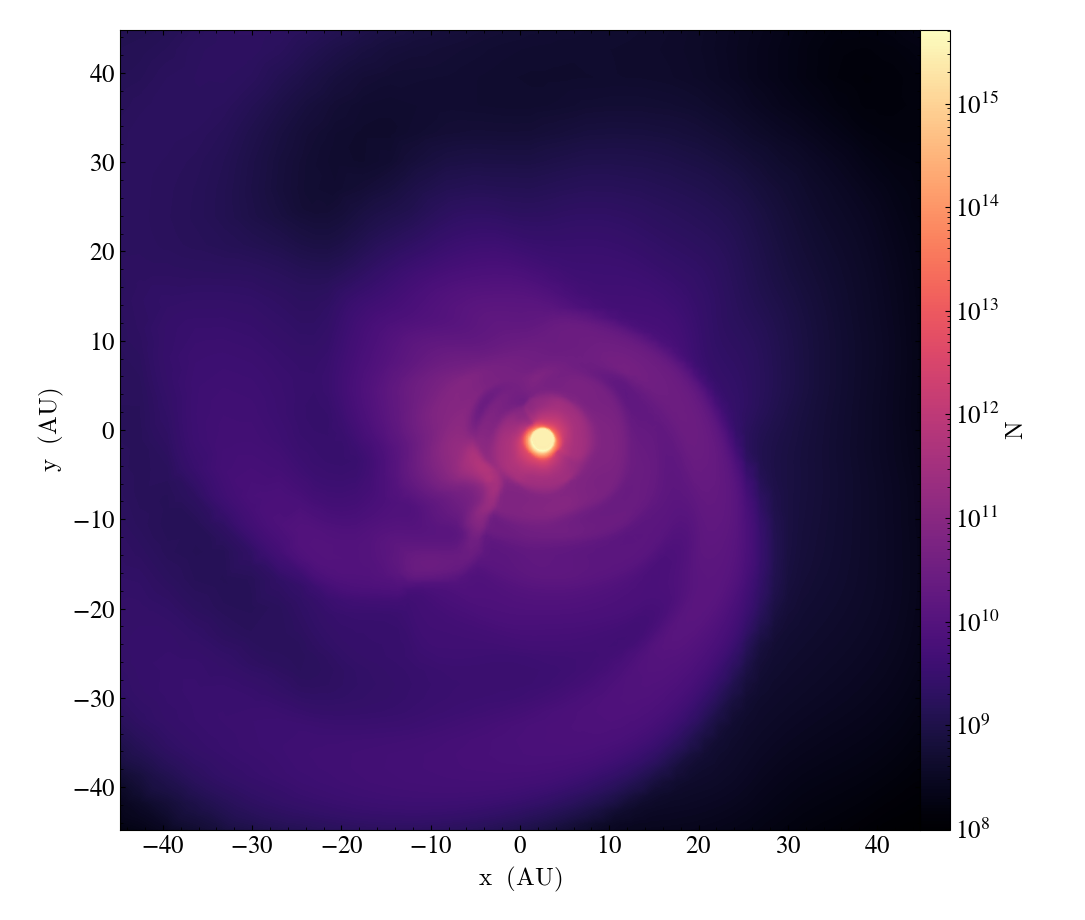

In [10]:
sl = yt.SlicePlot (ds, 'z', ('connect1', 'n'))
sl.set_cmap       (('connect1', 'n'), 'magma')
sl.zoom           (1.2)

Show mesh on the plot.


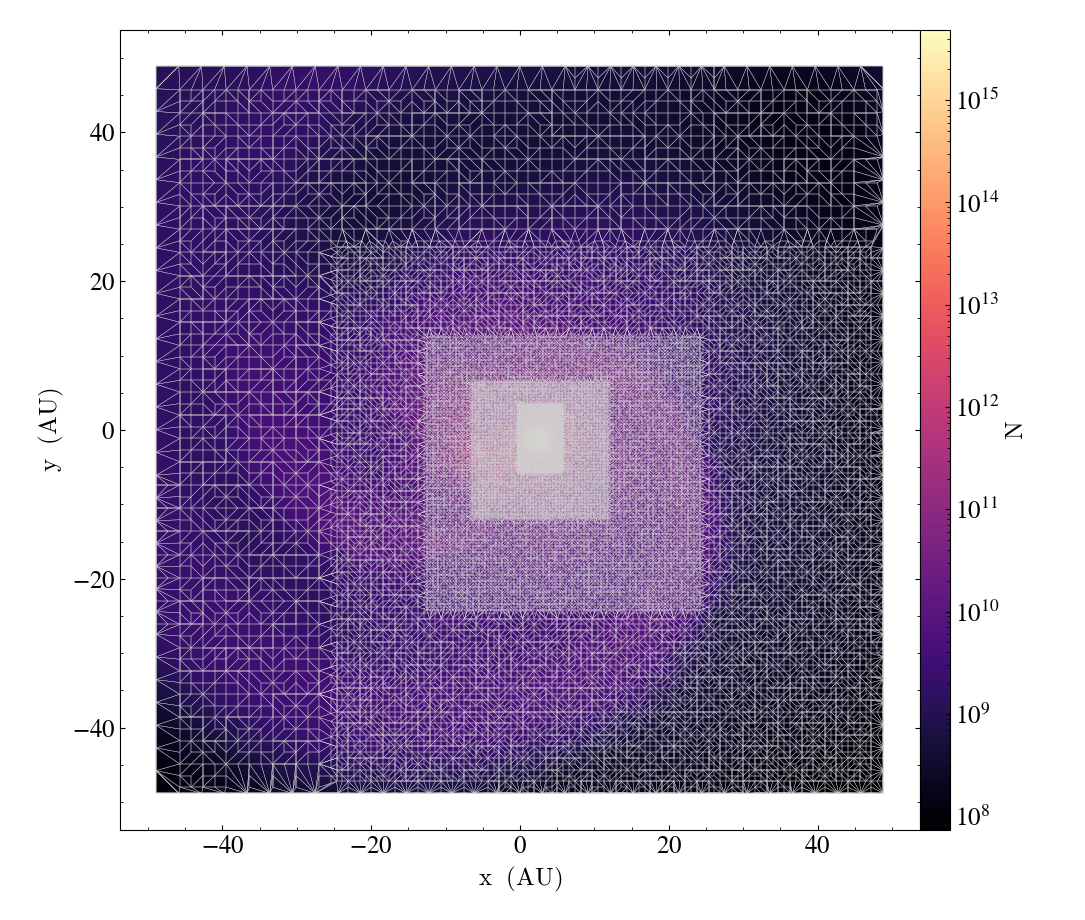

In [11]:
sl = yt.SlicePlot      (ds, 'z', ('connect1', 'n'))
sl.set_cmap            (('connect1', 'n'), 'magma')
sl.zoom                (1.0)
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.25]})

In the [next example](2_reduce_AMRVAC_3D.ipynb) we demonstrate how to reduce this model as in [De Ceuster et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020MNRAS.499.5194D/abstract).